In [59]:
from JupyterImport import *
from src.DataStandardize.ExpSpecific.Sep20 import Fixes
from src.DatObject.Attributes import SquareEntropy as SE, Transition as T, Entropy as E, DatAttribute as DA, Logs as L
root_logger.setLevel(logging.WARNING)

In [229]:
# dats = get_dats(range(363, 366+1))  # Test Entropy measurements with no Channel Bias, first two 0mT second two -100mT field 100mK
# dats = get_dats(range(368, 373+1))  # Measurements a bit noisy, not quite a full set 100mK, -100mT
# dats = get_dats(range(374, 377+1))  # Accidentally measured 1-> 2 transition 100mK, -100mT
# dats = get_dats(range(378, 384+1))  # 0 -> 1 transition with -0.035 ratio (which turned out to be a bit too high) -100mT field, 100mK
# dats = get_dats(range(385, 389+1))  # 0 -> 1 transition with -0.028 ratio (best from above) -100mT, 100mK
dats = get_dats(range(488, 517+1))  # Along 0->1 transition starting from gamma broadened, -100mT, 100mK, gamma broadened scans are wider -- Not enough heating

# dats = get_dats(range(518, 547+1))

save_graphs=False
filter_on = True

100% (30 of 30) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [235]:
for dat in dats:
    print(f"Dat{dat.datnum}: LCT={dat.Logs.fds['LCT']}")

Dat488: LCT=-319.82
Dat489: LCT=-322.27
Dat490: LCT=-324.71
Dat491: LCT=-329.89
Dat492: LCT=-334.78
Dat493: LCT=-339.97
Dat494: LCT=-344.85
Dat495: LCT=-349.73
Dat496: LCT=-354.92
Dat497: LCT=-359.8
Dat498: LCT=-364.99
Dat499: LCT=-369.87
Dat500: LCT=-379.94
Dat501: LCT=-389.71
Dat502: LCT=-399.78
Dat503: LCT=-409.85
Dat505: LCT=-429.99
Dat506: LCT=-439.76
Dat507: LCT=-449.83
Dat508: LCT=-459.9
Dat509: LCT=-469.97
Dat510: LCT=-479.74
Dat511: LCT=-489.81
Dat512: LCT=-499.88
Dat513: LCT=-509.95
Dat514: LCT=-519.71
Dat515: LCT=-529.79
Dat516: LCT=-539.86
Dat517: LCT=-579.83


In [230]:
for dat in progressbar(dats, redirect_stdout=False):
        if 'LS625 Magnet Supply' in dat.Logs.full_sweeplogs.keys():
            Fixes._add_magy(dat)  # Adds temporary magy field to Other.magy
        else:
            dat.Other.magy = L.MAGs(name='magy', field=0, rate='50')
        dat.SquareEntropy.Processed.plot_info.show = SE.ShowPlots(info=True, raw=True, averaged=True, entropy=True)
        dat.SquareEntropy.ShowPlots.integrated = True
dats = [dat for dat in dats if dat.SquareEntropy.Processed.outputs.entropy_fit is not None]

100% (30 of 30) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [231]:
for dat in dats:
    if dat.Logs.fds['LCT'] > -345:  # Force blind averaging for super gamma broadened dats
        print(f'Resetting Square Entropy stuff for Dat{dat.datnum}')
        fi = DA.FitInfo()
        out = dat.SquareEntropy.Processed.outputs
        inp = dat.SquareEntropy.Processed.inputs
        out.averaged = np.mean(out.cycled, axis=0)
        x = np.linspace(out.x[0], out.x[-1], out.averaged.shape[-1])
        
        fit = E.entropy_fits(x, out.averaged)[0]
        fi.init_from_fit(fit)
        out.entropy_fit = fi
        dat.SquareEntropy.Processed.outputs = out

Resetting Square Entropy stuff for Dat488
Resetting Square Entropy stuff for Dat489
Resetting Square Entropy stuff for Dat490
Resetting Square Entropy stuff for Dat491
Resetting Square Entropy stuff for Dat492
Resetting Square Entropy stuff for Dat493
Resetting Square Entropy stuff for Dat494


In [232]:
xs, trans_datas, entropy_datas, integrated_datas, ids, trans_titles, entropy_titles, integrated_titles, tcs, ths, dTs = list(), list(), list(), list(), list(), list(), list(), list(), list(), list(), list()
line = lm.models.LinearModel()
for dat in progressbar(dats):

    x = dat.SquareEntropy.Processed.outputs.x
    
    ids.append(f'{dat.datnum}')
    
    dat_tcs, dat_amps = list(), list()
    for data in dat.SquareEntropy.Processed.outputs.averaged[0::2]:
        fit = T.transition_fits(x, data, func=T.i_sense)[0]
        dat_tcs.append(fit.best_values['theta'])
        dat_amps.append(fit.best_values['amp'])
    dat_ths = list()
    for data in dat.SquareEntropy.Processed.outputs.averaged[1::2]:
        fit = T.transition_fits(x, data, func=T.i_sense)[0]
        dat_ths.append(fit.best_values['theta'])
    tc = np.nanmean(dat_tcs)
    th = np.nanmean(dat_ths)
    dT = th-tc
    tcs.append(tc)
    ths.append(th)
    dTs.append(dT)
    
    
    if 0.2 < amp < 1 and 1 < dT < 7:
        amp = np.average(dat_amps)
        dat.SquareEntropy.Processed.inputs.dT = dT
        dat.SquareEntropy.Processed.inputs.transition_amplitude = amp
        dat.SquareEntropy.process()
        integrated_data = dat.SquareEntropy.Processed.outputs.integrated_entropy
        indexs = CU.get_data_index(x, [-1500, -1000])
        line_fit = line.fit(integrated_data[indexs[0]:indexs[1]], x=x[indexs[0]:indexs[1]], nan_policy='omit')
        integrated_data = integrated_data-line_fit.eval(x=x)
    else:  # Manually calculate integrated (processing will mess up stuff)
        out = dat.SquareEntropy.Processed.outputs
        dx = np.mean(np.diff(x))
        dt = 4
        amp = amp if 0.2 < amp < 1 else 0.7
        out.entropy_signal = SE.entropy_signal(out.averaged)
        sf = SE.scaling(dt=dt, amplitude=amp, dx=dx)
        int_info = SE.IntegratedInfo(dT=dt, amp=amp, dx=dx)
        print(int_info)
        out.integrated_entropy = SE.integrate_entropy(out.entropy_signal, int_info.sf)
        int_info.dS = out.integrated_entropy[-1]
        out.integrated_info = int_info
        integrated_data = out.integrated_entropy
#         indexs = CU.get_data_index(x, [-4500, -2500])
#         line_fit = line.fit(integrated_data[indexs[0]:indexs[1]], x=x[indexs[0]:indexs[1]], nan_policy='omit')
#         integrated_data = integrated_data-line_fit.eval(x=x)
    
    
    e_signal = dat.SquareEntropy.Processed.outputs.entropy_signal
    e_pars = CU.edit_params(dat.SquareEntropy.Processed.outputs.entropy_fit.params, 'const', 0, True)
    efit = E.entropy_fits(x, e_signal, params=e_pars)[0]
    efit_info = DA.FitInfo()
    efit_info.init_from_fit(efit)
    
    td = dat.SquareEntropy.Processed.outputs.averaged
    ed = [efit_info.eval_fit(x=x), e_signal]
    intd = integrated_data
    if filter_on is True:
        scan_freq = dat.Logs.Fastdac.measure_freq/dat.AWG.info.wave_len
        num_steps = dat.AWG.info.num_steps
        decimate_factor = int(np.floor(num_steps/200))
        if decimate_factor >= 2:
            td = CU.decimate(td, scan_freq, decimate_factor=decimate_factor)
            x = np.linspace(x[0], x[-1], td.shape[-1])
            ed = [efit_info.eval_fit(x=x), CU.decimate(ed[1], scan_freq, decimate_factor=decimate_factor)]
            intd = CU.decimate(intd, scan_freq, decimate_factor=decimate_factor)
        else:
            pass  # Decimate factor must be 2 or more
    else:
        pass
    xs.append(x)
    trans_datas.append(td)
    entropy_datas.append(ed)
    integrated_datas.append(intd)
    
    channel_ratio = round(dat.AWG.AWs[1][0][1]/dat.AWG.AWs[0][0][1]/-0.028, 2)
    dsp = dat.SquareEntropy.Processed
    ii = dsp.outputs.integrated_info
    fit_text = f'SF={ii.sf:.2f}, Amp={ii.amp:.3f}nA, T_cold={tc:.3f}mV, T_hot={th:.3f}mV, dT={dT:.3f}mV, fit_dS={efit_info.best_values.dS:.3f}kB'
    scan_text = f'HQPCbiases=({dat.AWG.AWs[0][0][1]:.0f}mV, {dat.AWG.AWs[0][0][3]:.0f}mV), Channel Biases=({dat.AWG.AWs[1][0][1]:.1f}mV, {dat.AWG.AWs[1][0][3]:.1f}mV), Perp Field={dat.Other.magy.field:.1f}mT'
    array_text = f'Channel Bias Ratio = {channel_ratio}, Square Wave Frequency = {scan_freq:.1f}Hz, Sweeprate (LP*200) = {dat.Logs.sweeprate:.1f}mV/s'
    text_info = f'{array_text}<br>{scan_text}<br>{fit_text}'
    trans_titles.append(f'Dat{dat.datnum}: Averaged CS data<br>{text_info}')
    entropy_titles.append(f'Dat{dat.datnum}: Entropy data with fit<br>{text_info}')
    integrated_titles.append(f'Dat{dat.datnum}: Integrated Entropy data<br>{text_info}')
    
    
fig1 = PlU.get_figure(datas=trans_datas, xs=xs, ids=ids, titles=trans_titles, labels=['v0_0', 'vp', 'v0_1', 'vm'], xlabel=f'{dat.Logs.x_label}', ylabel='Current /nA', plot_kwargs={'mode':'lines+markers'})
fig2 = PlU.get_figure(datas=entropy_datas, xs=xs, ids=ids, titles=entropy_titles, labels=['fit', 'data'], xlabel=f'{dat.Logs.x_label}', ylabel='Current /nA', plot_kwargs={'mode':'lines+markers'})
fig3 = PlU.get_figure(datas=integrated_datas, xs=xs, ids=ids, titles=integrated_titles, xlabel=f'{dat.Logs.x_label}', ylabel='Entropy /kB', plot_kwargs={'mode':'lines+markers'})

  3% (1 of 29) |                         | Elapsed Time: 0:00:00 ETA:   0:00:08

IntegratedInfo(dT=4, amp=0.7, dx=4.39882697947214, dS=None)


 10% (3 of 29) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:06

IntegratedInfo(dT=4, amp=0.7, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.7, dx=4.39882697947214, dS=None)


 13% (4 of 29) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:05

IntegratedInfo(dT=4, amp=0.7, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.7, dx=4.39882697947214, dS=None)

 17% (5 of 29) |####                     | Elapsed Time: 0:00:01 ETA:   0:00:05

 27% (8 of 29) |######                   | Elapsed Time: 0:00:02 ETA:   0:00:06

IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)


 41% (12 of 29) |#########               | Elapsed Time: 0:00:02 ETA:   0:00:03

IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)

 51% (15 of 29) |############            | Elapsed Time: 0:00:02 ETA:   0:00:02


IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)


 62% (18 of 29) |##############          | Elapsed Time: 0:00:03 ETA:   0:00:01

IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)


 75% (22 of 29) |##################      | Elapsed Time: 0:00:03 ETA:   0:00:00

IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)


 86% (25 of 29) |####################    | Elapsed Time: 0:00:03 ETA:   0:00:00

IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)


100% (29 of 29) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)
IntegratedInfo(dT=4, amp=0.5957866792067456, dx=4.39882697947214, dS=None)


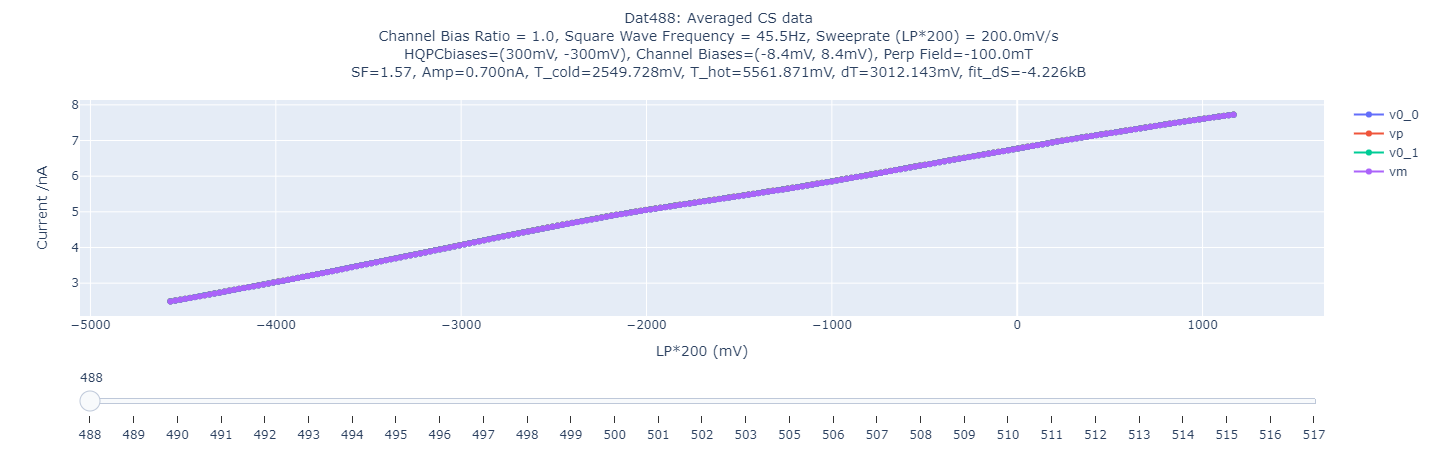

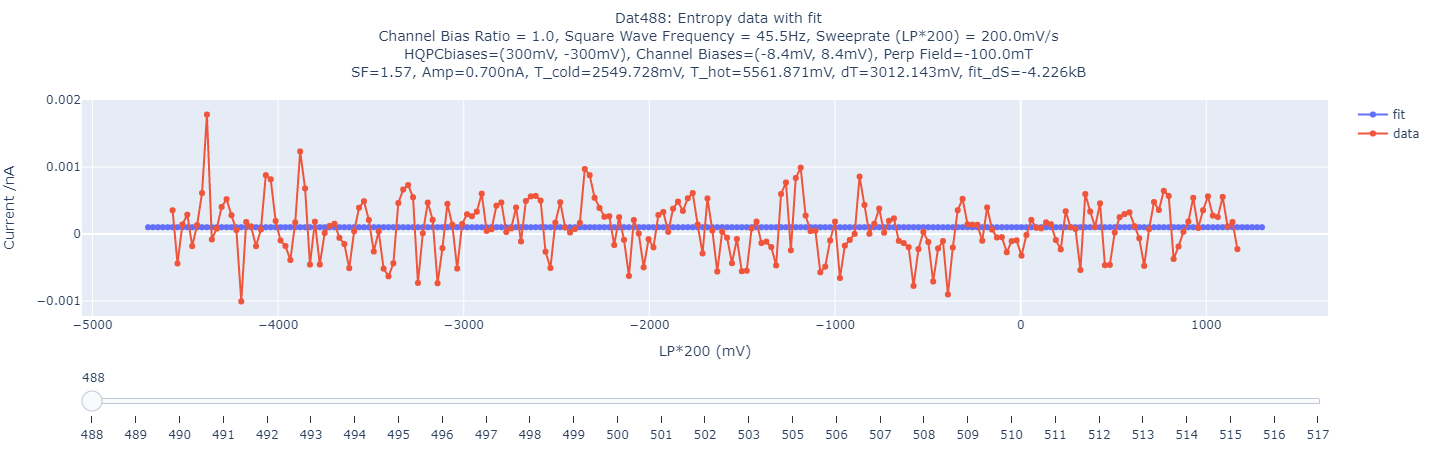

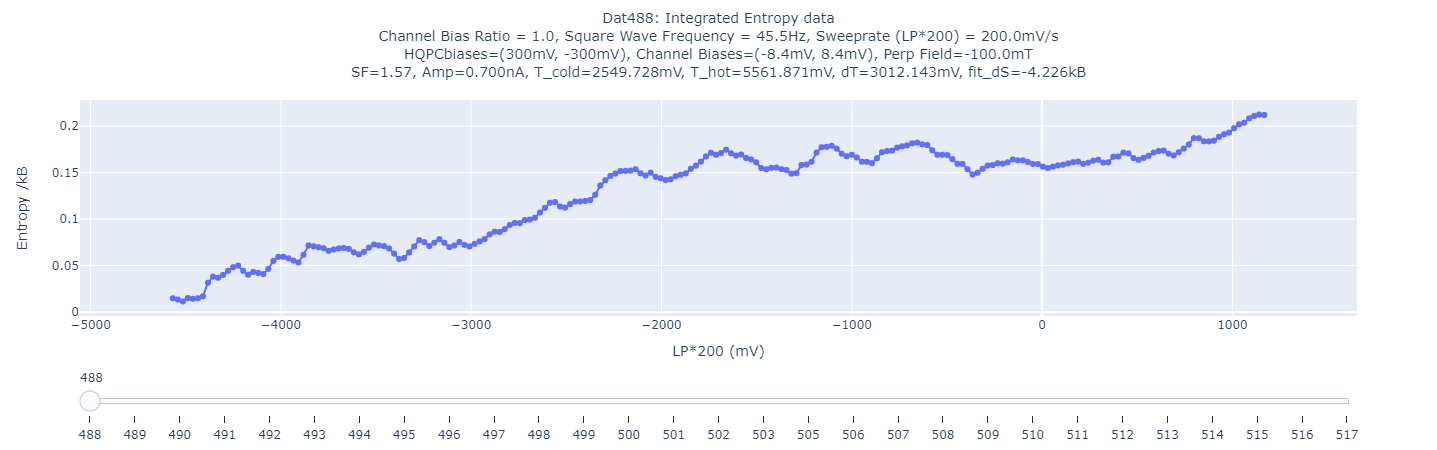

In [233]:
for fig, name in zip([fig1, fig2, fig3], ['AveragedCS_vs_Channel_bias', 'Average_Entropy_With_Fit', 'Averaged_Integrated_Entropy']):
    fig.update_layout(hovermode = 'x unified',
                     title=dict(y=0.95,x=0.5,xanchor='center',yanchor='top', font=dict(size=14)))
    if save_graphs: 
        fig.write_html(export_path+f'Dats{dats[0].datnum}-{dats[-1].datnum}{name}.html')
    fig.show()